In [1]:
!pip install geopandas plotly statsmodels pycountry


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 19.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import geopandas as gpd
import pycountry

sns.set(style="whitegrid")


In [3]:
df = pd.read_csv("/content/01_Final_Dataset_With_Topics.csv")

print(df.columns)
print("Total documents:", len(df))


Index(['PMID', 'Title', 'Abstract', 'Journal', 'Year', 'Authors', 'Keywords',
       'MeSH', 'PubType', 'Title_clean', 'Abstract_clean', 'full_text', 'text',
       'Topic'],
      dtype='object')
Total documents: 189


In [4]:
df = df[df["Topic"] != -1]
df["Topic"] = df["Topic"].astype(int)


TIME TREND ANALYSIS

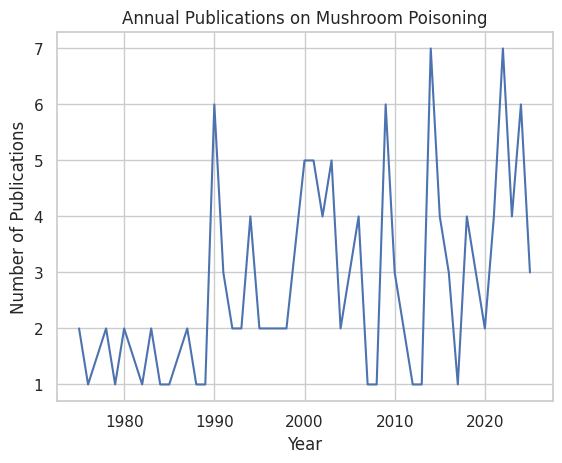

In [5]:
year_counts = df.groupby("Year").size()

plt.figure()
year_counts.plot()
plt.xlabel("Year")
plt.ylabel("Number of Publications")
plt.title("Annual Publications on Mushroom Poisoning")
plt.show()


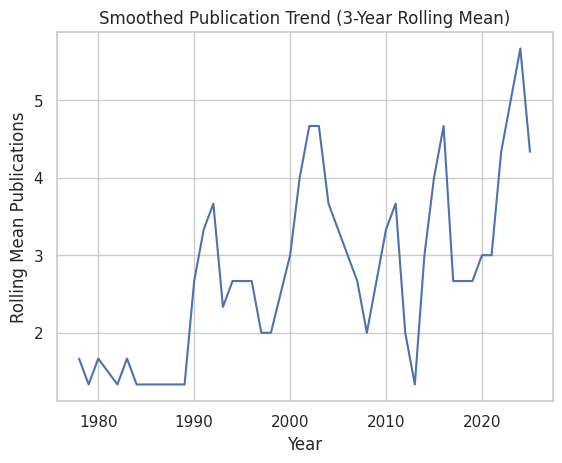

In [6]:
rolling = year_counts.rolling(3).mean()

plt.figure()
rolling.plot()
plt.xlabel("Year")
plt.ylabel("Rolling Mean Publications")
plt.title("Smoothed Publication Trend (3-Year Rolling Mean)")
plt.show()


<Figure size 640x480 with 0 Axes>

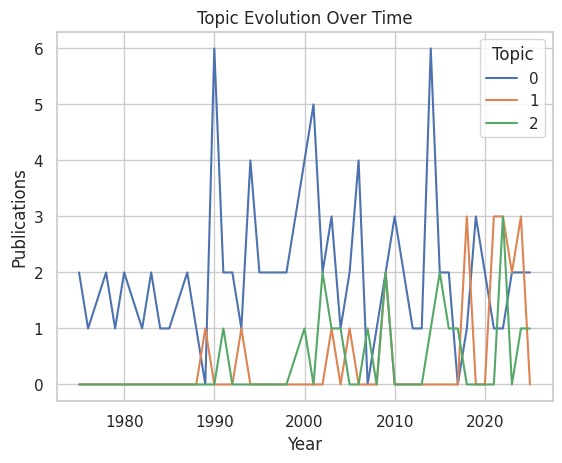

In [7]:
topic_year = df.groupby(["Year", "Topic"]).size().unstack(fill_value=0)

plt.figure()
topic_year.plot()
plt.xlabel("Year")
plt.ylabel("Publications")
plt.title("Topic Evolution Over Time")
plt.show()


In [35]:
df_year = year_counts.reset_index()
df_year.columns = ["Year", "Count"]

df_year["Year_centered"] = df_year["Year"] - df_year["Year"].min()

model = sm.GLM(df_year["Count"],
               sm.add_constant(df_year["Year_centered"]),
               family=sm.families.Poisson()).fit()

print(model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Count   No. Observations:                   47
Model:                            GLM   Df Residuals:                       45
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -83.583
Date:                Fri, 20 Feb 2026   Deviance:                       36.733
Time:                        05:06:43   Pearson chi2:                     37.9
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1890
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5008      0.206      2.434

In [36]:
for topic in df["Topic"].unique():
    subset = df[df["Topic"] == topic]
    yearly = subset.groupby("Year").size().reset_index()
    yearly.columns = ["Year", "Count"]
    yearly["Year_centered"] = yearly["Year"] - yearly["Year"].min()

    model = sm.GLM(yearly["Count"],
                   sm.add_constant(yearly["Year_centered"]),
                   family=sm.families.Poisson()).fit()

    print(f"\nTopic {topic} Trend:")
    print(model.summary())



Topic 2 Trend:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Count   No. Observations:                   14
Model:                            GLM   Df Residuals:                       12
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16.989
Date:                Fri, 20 Feb 2026   Deviance:                       3.1447
Time:                        05:06:50   Pearson chi2:                     3.51
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01138
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1128      

In [37]:
# Overall yearly counts
year_counts = (
    df.groupby("Year")
      .size()
      .reset_index(name="Total_Publications")
      .sort_values("Year")
)

# 3-year rolling mean
year_counts["Rolling_Mean_3yr"] = (
    year_counts["Total_Publications"]
    .rolling(window=3, center=True)
    .mean()
)

year_counts.to_csv("overall_year_trend.csv", index=False)

year_counts.head()


,Year,Total_Publications,Rolling_Mean_3yr
0,1975,2,NaN
1,1976,1,1.666667
2,1978,2,1.333333
3,1979,1,1.666667
4,1980,2,1.333333


In [38]:
# Overall yearly counts
year_counts = (
    df.groupby("Year")
      .size()
      .reset_index(name="Total_Publications")
      .sort_values("Year")
)

# 3-year rolling mean
year_counts["Rolling_Mean_3yr"] = (
    year_counts["Total_Publications"]
    .rolling(window=3, center=True)
    .mean()
)

year_counts.to_csv("overall_year_trend.csv", index=False)

year_counts.head()


,Year,Total_Publications,Rolling_Mean_3yr
0,1975,2,NaN
1,1976,1,1.666667
2,1978,2,1.333333
3,1979,1,1.666667
4,1980,2,1.333333


In [39]:
topic_year_counts = (
    df.groupby(["Year", "Topic"])
      .size()
      .reset_index(name="Count")
      .sort_values(["Year", "Topic"])
)

topic_year_counts.to_csv("topic_year_trend.csv", index=False)

topic_year_counts.head()


,Year,Topic,Count
0,1975,0,2
1,1976,0,1
2,1978,0,2
3,1979,0,1
4,1980,0,2


In [42]:
!pip install pycountry


In [43]:
import pycountry
import re

# Get official country names
countries = [country.name for country in pycountry.countries]

# Add common variations manually
extra_names = [
    "USA", "United States", "UK", "United Kingdom",
    "Iran", "Russia", "South Korea", "North Korea"
]

country_list = countries + extra_names


def extract_country(text):
    if pd.isna(text):
        return None
    for country in country_list:
        if re.search(r"\b" + re.escape(country) + r"\b", text):
            return country
    return None


In [44]:
df["Extracted_Country"] = df["Abstract"].apply(extract_country)

df["Extracted_Country"].value_counts().head()


,count
Extracted_Country,
China,5
Japan,4
United States,4
Thailand,2
France,2


In [46]:
geo_topic_counts = (
    df[df["Extracted_Country"].notna()]
    .groupby(["Extracted_Country", "Topic"])
    .size()
    .reset_index(name="Count")
)

geo_topic_counts.head()


,Extracted_Country,Topic,Count
0,Australia,0,2
1,Brazil,0,1
2,Bulgaria,0,1
3,Chile,0,1
4,China,1,4


In [47]:
geo_topic_counts = (
    df[df["Extracted_Country"].notna()]
    .groupby(["Extracted_Country", "Topic"])
    .size()
    .reset_index(name="Count")
    .sort_values("Count", ascending=False)
)

geo_topic_counts.to_csv("country_topic_matrix.csv", index=False)

geo_topic_counts.head()


,Extracted_Country,Topic,Count
4,China,1,4
21,United States,0,3
14,Japan,1,3
9,Germany,0,2
20,Thailand,1,2


In [48]:
geo_topic_counts = (
    df[df["Extracted_Country"].notna()]
    .groupby(["Extracted_Country", "Topic"])
    .size()
    .reset_index(name="Count")
    .sort_values("Count", ascending=False)
)

geo_topic_counts.to_csv("country_topic_matrix.csv", index=False)

geo_topic_counts.head()


,Extracted_Country,Topic,Count
4,China,1,4
21,United States,0,3
14,Japan,1,3
9,Germany,0,2
20,Thailand,1,2


In [49]:
country_year_counts = (
    df[df["Extracted_Country"].notna()]
    .groupby(["Extracted_Country", "Year"])
    .size()
    .reset_index(name="Count")
)

country_year_counts.to_csv("country_year_trend.csv", index=False)


In [50]:
from google.colab import files

files.download("overall_year_trend.csv")
files.download("topic_year_trend.csv")
files.download("country_topic_matrix.csv")
files.download("country_year_trend.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>